# Company Churn Prediction
Creating a simple Randomforest Classifier from records about companies, industry, revenue, # of employee... using SageMaker SDK

In [2]:
import numpy as np
import pandas as pd
import boto3
import re, os
import sagemaker
from pandas.api.types import CategoricalDtype

In [3]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name
data_bucket = sess.default_bucket()

In [4]:
PREFIX = "company-churn"
data_file = "companies.csv"


## Build the training and validation data sets

Be sure to have the companies.csv file on local folder, or run the simulator to create data

In [ ]:
datafile_path=os.path.join("./", data_file)
df = pd.read_csv(datafile_path)
df.info()

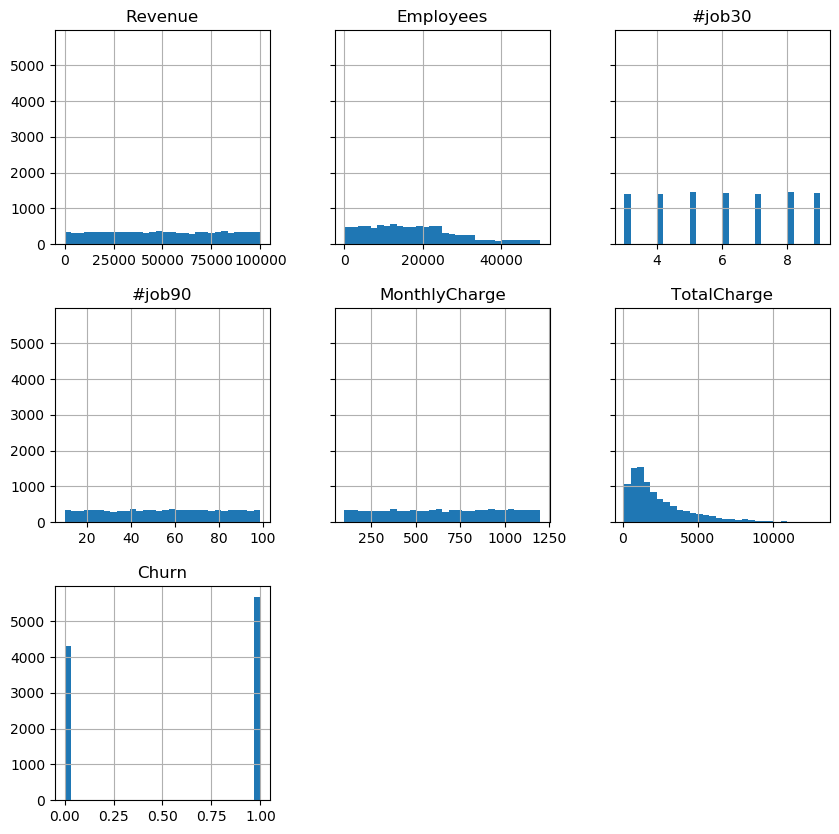

In [6]:
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [7]:
industryCat = df["Industry"].unique()
industry_type = CategoricalDtype(categories=industryCat)
df = df.drop(['Company'],axis=1)
df = pd.get_dummies(df,columns=['Industry'])

In [8]:
train_data, test_data, _ = np.split(df.sample(frac=1, random_state=1729), [int(0.8 * len(df)), len(df)])
train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [9]:
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(PREFIX, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(PREFIX, 'validation/test.csv')).upload_file('test.csv')


In [10]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{data_bucket}/{PREFIX}/train"
print(f"training files will be taken from: {s3_train_data}")

s3_validation_data = f"s3://{data_bucket}/{PREFIX}/validation"
print(f"validtion files will be taken from: {s3_validation_data}")

s3_test_data = f"s3://{data_bucket}/{PREFIX}/test"
print(f"test files will be taken from: {s3_test_data}")

output_location = f"s3://{data_bucket}/{PREFIX}/output"
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

training files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/train
validtion files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/validation
test files will be taken from: s3://sagemaker-us-west-2-403993201276/company-churn/test
training artifacts output location: s3://sagemaker-us-west-2-403993201276/company-churn/output


In [11]:
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name, version="1")
print(container)

174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1


In [ ]:
from time import gmtime, strftime
job_name = "Linear-learner-company-churn-" + strftime("%H-%M-%S", gmtime())
print("Training job", job_name)

linear = sagemaker.estimator.Estimator(
    container,
    role,
    input_mode="File",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)

linear.set_hyperparameters(
    epochs=16,
    wd=0.01,
    loss="absolute_loss",
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=1000,
    lr_scheduler_step=100,
    lr_scheduler_factor=0.99,
    lr_scheduler_minimum_lr=0.0001,
    learning_rate=0.1,
)
linear.fit(inputs={"train": train_data, "validation": validation_data}, job_name=job_name)

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")
print(f"\ncreated endpoint: {linear_predictor.endpoint_name}")

In [14]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

In [25]:
import random
FILE_TEST="test.csv"
s3 = boto3.client("s3")
s3.download_file(data_bucket,f"{PREFIX}/validation/{FILE_TEST}",FILE_TEST)
test_data =[l for l in open(FILE_TEST,'r')]
sample = random.choice(test_data).split(",")
payload=",".join(map(str,sample[:15]))
print(payload)

19100,9550,6,39,227,810,0,0,0,0,0,0,1,0,0


In [26]:
result=linear_predictor.predict(payload)
print(result)

{'predictions': [{'score': -2170327.0}]}
